# NLPeasy Demonstration

> Harness your textual data!

In this demo you will use NLPEasy to quickly setup a Pandas-based pipeline, enhanced with ML-Methods and pre-trained models (e.g. word embeddings, sentiment analysis). The results will then be saved in Elasticsearch and a Kibana dashboard is generated automatically to explore the texts and results.

## Installation

For this example to completely work you need to have Python at least in Version 3.6 installed.
Also you need to have install and start either

- **Docker** <https://www.docker.com/get-started>, direct download links for
    [Mac (DMG)](https://download.docker.com/mac/stable/Docker.dmg) and
    [Windows (exe)](https://download.docker.com/win/stable/Docker%20for%20Windows%20Installer.exe).
- **Elasticsearch** and **Kibana**:
<https://www.elastic.co/downloads/> or
<https://www.elastic.co/downloads/elasticsearch-oss> (pure Apache licensed version)

Then either on the terminal or inside this notebook issue:

The package `scikit-learn` is just used in this example to get the newsgroups data and preprocess it.
The last command downloads a spacy model for the english language -
for the following you need to have at least it's `md` (=medium) version which has wordvectors.

## Imports

In [1]:
import pandas as pd
import nlpeasy as ne

For this example we will use the Newsgroups data from scikit-learn, and also clustering algorithms, as well as matplotlib for plotting.
So you might wanna install these as well:

In [2]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
%matplotlib inline

## Connect to Elastic Stack

Connect to running elastic or else start an Open Source stack on your docker

In [3]:
elk = ne.connect_elastic(docker_prefix='nlp', elk_version='7.4.0',
                         mount_volume_prefix=None)

'No elasticsearch on localhost:9200 found, trying connect to docker container with prefix nlp'

'No docker container with prefix nlp; starting one'

ElasticSearch on http://localhost:32784
Kibana on http://localhost:32785

> If it is started on docker it will on the first time pull the images (1.3GB)!
BTW, this function is not blocking, i.e. the servers might only be active couple of seconds later.
Setting mountVolumePrefix="./elastic-data/" would keep the data of elastic in your
filesystems and then the data survives container restarts

## Read and Process Data

Read data as Pandas data frame. For this simple example we remove all additional newsgroups infos - it would be interesting to investigate that though...

In [4]:
news_raw = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
news_groups = [news_raw['target_names'][i] for i in news_raw['target']]
news = pd.DataFrame({'newsgroup': news_groups, 'message': news_raw['data']})
print(news.shape)
news.head()

(11314, 2)


,newsgroup,message
0,rec.autos,I was wondering if anyone out there could enli...
1,comp.sys.mac.hardware,A fair number of brave souls who upgraded thei...
2,comp.sys.mac.hardware,"well folks, my mac plus finally gave up the gh..."
3,comp.graphics,\nDo you have Weitek's address/phone number? ...
4,sci.space,"From article <C5owCB.n3p@world.std.com>, by to..."


Now we create a NLPeasy-Pipeline object:

In [5]:
pipeline = ne.Pipeline(index='news',
                       text_cols=['message'], tag_cols=['group'],
                       elk=elk)

The parameters here have some meening:
* `index` will be the name of the Elasticsearch index (something like a Database name).
* `textCols` here you can specify which columns of the dataframe are textual.
* `tagCols` will be used for barplots in Kibana.
* `elk` is the Elastic stack we connected to above.

Now let's add 2 stages in the pipeline - the spacy model takes ~30 secs to load.

In [6]:
pipeline += ne.VaderSentiment('message', 'sentiment')
pipeline += ne.SpacyEnrichment(nlp='en_core_web_md', cols=['message'], vec=True)

NLPeasy pipelines can hava as few or as many stages as you wish. Here we just use the following:
* `VaderSentiment` is a nice rule-based sentiment prediction for english.
* `Spacy` uses the `spacy` package together with it's language model - here the english medium (=md). We use it for a couple of enrichments, as you will see below. Please try to add your own ones! Here we activated `vec=True` (default is `False`) in order to use the Spacy-WordEmbeddings later for clustering.

There are more stages in NLPeasy you can use (e.g. RegexTag Extraction, Splitting) or you can define your own functions there.

Run the pipeline - Spacy needs some time to process, so these ~11000 messages take about 10 minutes to process.

In [7]:
news_enriched = pipeline.process(news, write_elastic=True)

11314/11314 [==============================] - 8:12 44ms/step


Create Kibana Dashboard of all the columns

In [8]:
pipeline.create_kibana_dashboard()

Trying to do a histogram on str values: -1.0 - 1.0
news: adding index-pattern
news: setting default index-pattern
news: adding search
news: adding visualisation for group
news: adding visualisation for message_ents
news: adding visualisation for message_subj
news: adding visualisation for message_verb
news: adding visualisation for message
news: adding visualisation for sentiment
news: adding dashboard
news: setting time defaults


Open Kibana in webbrowser

In [9]:
elk.show_kibana()

It should look like the following:

![Kibana Screenshot](demo_kibana.png)

## Analysing the Enrichments

You can either explore some of the enrichments in Kibana, or in the below (transposed) head. Here are some pointers:
* `sentiment` comes from the VaderSentiment Stage and is a float.
* The `SpacyEnrichment` stage added many columens for the `message`, hence they are prefixed by `message_*`.
* As we added above `vec=True` we have both a `message_vec` and `message_vec_normalized` column. Please look below for an example clustering of those.
* `message_ents` is a list of all the entities recognised by Spacy's Named Entity Recognition (NER). These can be in different classes (PERSON, PRODUCT, ORG, etc.) that appear in the various `message_entity_*` columens.
* `message_wc` and `message_num_*` give various statistics: WordCount (wc), as well as count by different parts of speech (POS).
* Finally `message_subj` and `message_verb` give you the list of subjects and verbs, resp. in all the sentences of the message. This is based on Spacy's Dependency Parsing.

In [10]:
news_enriched.head().T

,0,1,2,3,4
newsgroup,rec.autos,comp.sys.mac.hardware,comp.sys.mac.hardware,comp.graphics,sci.space
message,I was wondering if anyone out there could enli...,A fair number of brave souls who upgraded thei...,"well folks, my mac plus finally gave up the gh...",\nDo you have Weitek's address/phone number? ...,"From article <C5owCB.n3p@world.std.com>, by to..."
sentiment,0.6249,0.9468,0.9761,0.4215,-0.802
message_wc,114,109,391,25,97
message_entity_DATE,"[the other day, early 70s, years]",[the next two days],"[this weekend, 1985, day]",NaN,NaN
message_ents,"[the other day, early 70s, Bricklin, years]","[SI, hour, 800 and 1.4 m, the next two days]","[mac, this weekend, 512k, 1985, 160, 180, powe...",[Weitek],"[Tom A Baker, 213]"
message_entity_PERSON,[Bricklin],NaN,[Tom Willis ],[Weitek],[Tom A Baker]
message_subj,"[-PRON-, anyone, -PRON-, -PRON-, door, bumper,...","[number, who, speed, CPU, -PRON-, -PRON-]","[-PRON-, i, -PRON-, somebody, anybody, -PRON-,...","[-PRON-, -PRON-]","[understanding, error, that, -PRON-, -PRON-]"
message_verb,"[wonder, could, enlighten, see, look, call, kn...","[upgrade, share, send, detail, attain, rate, a...","[give, start, intend, look, pick, can, answer,...","[would, like]","[expect, know, check, set, fix, introduce, tel..."
message_num_PRON,10,3,25,2,4


## Clustering the Newsgroups

Let's have some fun outside of Elastic/Kibana, just by using spacy's word embeddings:

In [11]:
#
grouped = news_enriched.loc[~news_enriched.message_vec_normalized.isna()].groupby('newsgroup')
group_vec = grouped.apply(lambda z: np.stack(z.message_vec_normalized.values).mean(axis=0))
clust = linkage(np.stack(group_vec), 'ward')

> *NOTE*: the word embeddings from spaCy's language models are not the best to use for such settings. If you intend to use Word Embeddings for this, please consider downloading: pretrained [FastText-Wordvectors](https://fasttext.cc/docs/en/pretrained-vectors.html) (each ~7GB).

How does it look?

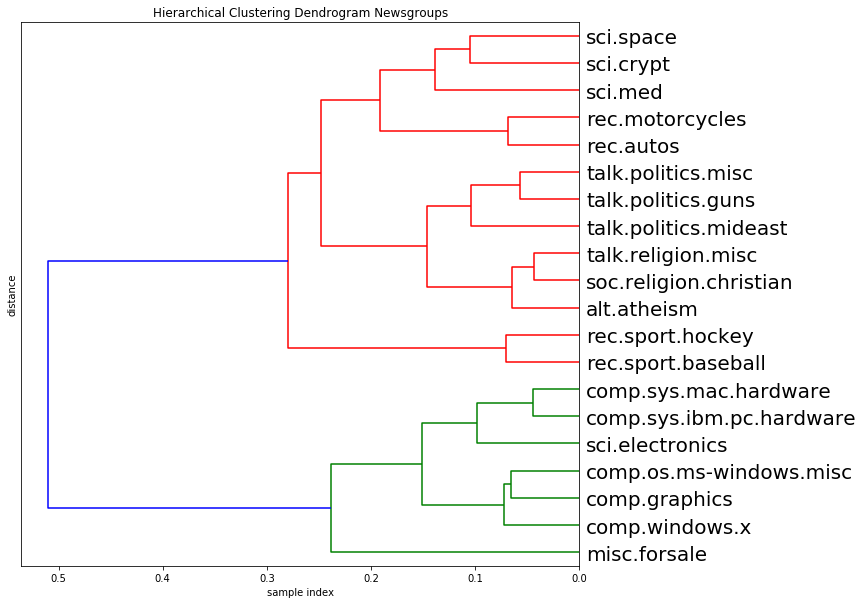

In [12]:
plt.figure(figsize=(10, 10))
plt.title('Hierarchical Clustering Dendrogram Newsgroups')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    clust,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
    labels=group_vec.index,
    orientation='left'
)
plt.show()

This already looks quite nice - how would it look with the FastText-Vectors...?

## Shutdown

If elastic was started on Docker and you want to shutdown the servers issue:

> *Warning*: If you didn't use a mountVolumePrefix when you started the servers, all the data in elastic and kibana will be lost!